In [1]:
using GynC

scalings = [2.0 ^ (i * 5/15) for i in -15:12]
cs = map(x->Config(propvar=x*GynC.defaultpropvar), scalings)

cs = Config[Config(Lausanne(p), propvar=1/8*GynC.defaultpropvar, adapt=true, thin=100) for p in 1:55]

paths = map(c->joinpath("/nfs/datanumerik/bzfsikor/batch/",GynC.filename(c)), cs)

ss = map(GynC.load, paths[1:53]); # bug with 54?

    promote_rule(Type{Mamba.ScalarLogical}, Type{##105#T<:Real}) at /home/numerik/bzfsikor/.julia/v0.4/Mamba/src/variate.jl:20
is ambiguous with: 
    promote_rule(Type{#A<:Real}, Type{ForwardDiff.Dual{#N<:Any, #B<:Real}}) at /home/numerik/bzfsikor/.julia/v0.4/ForwardDiff/src/dual.jl:149.
To fix, define 
    promote_rule(Type{Mamba.ScalarLogical}, Type{ForwardDiff.Dual{#N<:Any, #B<:Real}})
before the new definition.
    promote_rule(Type{Mamba.ScalarStochastic}, Type{##108#T<:Real}) at /home/numerik/bzfsikor/.julia/v0.4/Mamba/src/variate.jl:20
is ambiguous with: 
    promote_rule(Type{#A<:Real}, Type{ForwardDiff.Dual{#N<:Any, #B<:Real}}) at /home/numerik/bzfsikor/.julia/v0.4/ForwardDiff/src/dual.jl:149.
To fix, define 
    promote_rule(Type{Mamba.ScalarStochastic}, Type{ForwardDiff.Dual{#N<:Any, #B<:Real}})
before the new definition.


53-element Array{GynC.Sampling,1}:
 Sampling
  samples: (100000,115)
  uniques: 95093
  config:  Config:
 patient: l1
 sigma:   0.1
 proposal variance: 0.125 x default trace, 0.0011819797559947422 top left
 adapt:   true
 thin:    100
 init:    4858380976513133059
 prior:   Tuple{Array{Distributions.Distribution{Distributions.Univariate,S<:Distributions.ValueSupport},1},Distributions.MixtureModel{Distributions.Multivariate,Distributions.Continuous,Distributions.MvNormal{PDMats.PDiagMat{Float64,Array{Float64,1}},Array{Float64,1}}}}  
 Sampling
  samples: (100000,115)
  uniques: 100000
  config:  Config:
 patient: l2
 sigma:   0.1
 proposal variance: 0.125 x default trace, 0.0011819797559947422 top left
 adapt:   true
 thin:    100
 init:    4858380976513133059
 prior:   Tuple{Array{Distributions.Distribution{Distributions.Univariate,S<:Distributions.ValueSupport},1},Distributions.MixtureModel{Distributions.Multivariate,Distributions.Continuous,Distributions.MvNormal{PDMats.PDiagMat{Floa

In [2]:
ssf = map(ss) do s
    l = size(s.samples,1)
    s[20_000:100:l, :]
end

map(s->size(s.samples,1), ssf) |> sum

42453

In [3]:
using ClusterManagers
rmprocs(workers())
slurm = addprocs(SlurmManager(20))
@everywhere using GynC
@time w = WeightedChain(ssf)
rmprocs(slurm)

1249.617907 seconds (56.01 M allocations: 5.945 GB, 0.09% gc time)


:ok

In [12]:
JLD.save("merged.jld", "w", w)


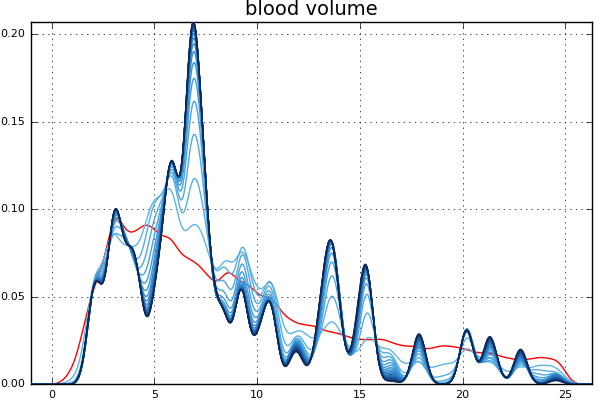

In [56]:
iters = 20
species = 8

cols = linspace(colorant"midnightblue",colorant"lightskyblue", iters+1)
cols = colormap("Blues", 1+2*iters)[iters+1:end]
cols[1] = colorant"red"

using Plots, KernelDensity
ww = deepcopy(w)
plot(legend=:none, title=GynC.samplednames[species])
for i=1:iters+1
    if i%1 == 0
        data = ww.samples[:,species]
        k = kde(data, npoints = 1000, weights = ww.weights, bandwidth=KernelDensity.default_bandwidth(data)/2)
        plot!(k.x, k.density, color=cols[i])
    end
    emiteration!(ww)
end
plot!()


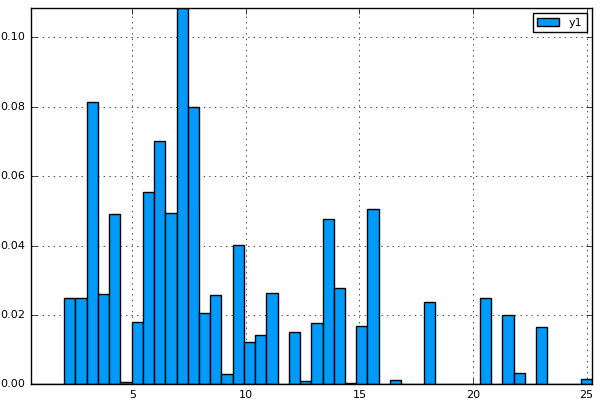

In [57]:
x, y = GynC.weightedhist(ww.samples[:,8], ww.weights, 50)
bar(x[1:end-1] + step(x),y)